# Convolution and Transposd Convolution

The need for transposed convolutions generally arises from the desire to use a transformation going in the opposite direction of a normal convolution, i.e., from something that has the shape of the output of some convolution to something that has the shape of its input while maintaining a connectivity pattern that is compatible with said convolution. For instance, one might use such a transformation as the decoding layer of a convolutional autoencoder or to project feature maps to a higher-dimensional space.

For example, when we use neural networks to generate images, it usually involves up-sampling from low resolution to high resolution.

There are various methods to conduct up-sample operation:

* Nearest neighbor interpolation
* Bi-linear interpolation
* Bi-cubic interpolation

All these methods involve some interpolation which we need to chose like a manual feature engineering that the network can not change later on.

Instead, we could use the transposed convolution which has learnable parameters [[1]](#ref1).

Examples of the transposed convolution usage:

* the generator in DCGAN takes randomly sampled values to produce a full-size image [[2]](#ref2).
* the semantic segmentation uses convolutional layers to extract features in the encoder and then restores the original image size in the encoder so that it can classify every pixel in the original image [[3]](#ref3).

The transposed convolution is also known as:

* Fractionally-strided convolution
* Deconvolution

But we will only use the word **transposed convolution** in this notebook.

One caution: the transposed convolution is the cause of the checkerboard artifacts in generated images [[4]](#ref4). The paper recommends an up-sampling followed by convolution to reduce such issues.  If the main objective is to generate images without such artifacts, it is worth considering one of the interpolation methods.

In [1]:
# setup path environment
import os
import sys

project_dir, _ = os.path.split(os.getcwd())
if project_dir not in sys.path:
    sys.path.append(project_dir)

# import packages for data manipulation and drawing
import pandas as pd
import numpy as np
import scipy as sp

# for ploting inline on the notebook
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('paper', font_scale=1.5)

from PIL import Image
import torch
from torch.nn import functional as F
from torchvision.transforms import functional as TF



In [11]:
def show_matrix(m, color, cmap, title=None):
    rows, cols = m.shape
    fig, ax = plt.subplots(figsize=(cols, rows))
    ax.set_yticks(list(range(rows)))
    ax.set_xticks(list(range(cols)))
    ax.xaxis.tick_top()  
    if title is not None:
        ax.set_title('{} {}'.format(title, m.shape), y=-0.5/rows)
    plt.imshow(m, cmap=cmap, vmin=0, vmax=255)
    plt.colorbar()
    ax.grid(None)
    for r in range(rows):
        for c in range(cols):
            text = '{:>3}'.format(int(m[r][c]))
            ax.text(c-0.2, r+0.15, text, color=color, fontsize=15)
    plt.show()
    
from functools import partial
show_inputs = partial(show_matrix, color='b', cmap=plt.cm.OrRd, title='Inputs')
show_kernel = partial(show_matrix, color='g', cmap=plt.cm.GnBu, title='Kernel')
show_output = partial(show_matrix, color='b', cmap=plt.cm.RdBu, title='Output')


In [15]:
partial??

## Convolution
--- 

$H_i, W_i$: height and width of the input

$k_h, k_w$: height and width of the kernel

$P$: padding

$S$: strides

$H_o, W_o$: height and width of the output

$W_o = {\lfloor}\frac{W_i - k_w + 2P}{S}{\rfloor} + 1$

$H_o = {\lfloor}\frac{H_i - k_h + 2P}{S}{\rfloor} + 1$

---

With the 4x4 matrix and 3x3 kernel with no zero padding and stride of 1:

${\lfloor}\frac{4 - 3 + 2\cdot 0}{1} + 1 {\rfloor}= 2$

So, with no zero padding and strides of 1, the convolution operation can be defined in a function like below:

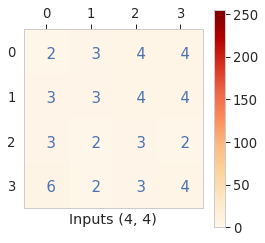

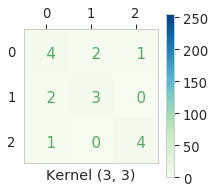

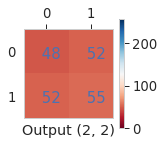

In [14]:
def no_pad_unit_stride_conv(m, k):
    m_rows, m_cols = m.shape # matrix rows, cols
    k_rows, k_cols = k.shape # kernel rows, cols

    rows = m_rows - k_rows + 1 # result matrix rows
    cols = m_rows - k_rows + 1 # result matrix cols
    
    v = np.zeros((rows, cols), dtype=m.dtype) # result matrix
    
    for r in range(rows):
        for c in range(cols):
            v[r][c] = np.sum(m[r:r+k_rows, c:c+k_cols] * k) # sum of the element-wise multiplication
    return v


inputs = np.random.randint(1, 9, size=(4, 4))
kernel = np.random.randint(0, 5, size=(3, 3))
output = no_pad_unit_stride_conv(inputs, kernel)

show_inputs(inputs)
show_kernel(kernel)
show_output(output)

# the first value is the inner product of inputs from the first sliding window and the kernel 
assert output[0][0], np.sum(inputs[0:3, 0:3] * kernel)

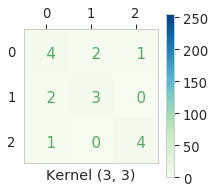

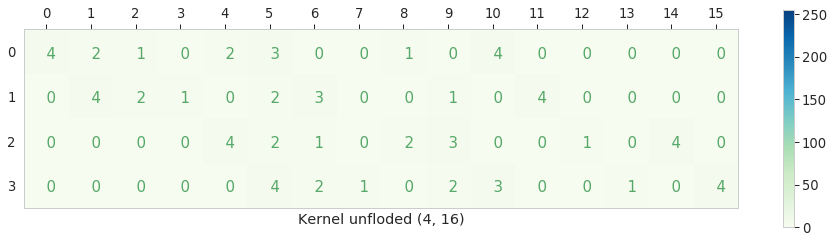

In [17]:
def no_pad_unit_stride_conv_matrix(m, k):
    m_rows, m_cols = m.shape # matrix rows, cols
    k_rows, k_cols = k.shape # kernel rows, cols

    # output matrix rows and cols
    rows = m_rows - k_rows + 1 
    cols = m_rows - k_rows + 1
    
    # convolution matrix
    v = np.zeros((rows*cols, m_rows, m_cols)) 

    for r in range(rows):
        for c in range(cols):
            i = r * cols + c
            v[i][r:r+k_rows, c:c+k_cols] = k

    v = v.reshape((rows*cols), -1)
    return v, rows, cols

kernel_unfloded, out_width, out_height = no_pad_unit_stride_conv_matrix(inputs, kernel)
show_kernel(kernel)
show_kernel(kernel_unfloded, title='Kernel unfloded')

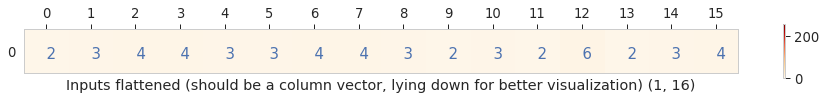

In [42]:
inputs_flattened = inputs.flatten()[None, :]
show_inputs(inputs_flattened, title='Inputs flattened (should be a column vector, lying down for better visualization)')


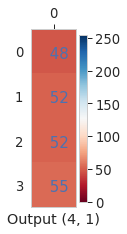

In [21]:
output_by_matrix_computation = kernel_unfloded @ inputs_flattened.transpose()
show_output(output_by_matrix_computation)


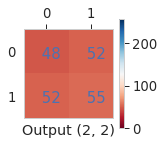

In [22]:
output_by_matrix_computation_reshaped = output_by_matrix_computation.reshape(2, 2)
show_output(output_by_matrix_computation_reshaped)


## Transpose Convolution

Now, suppose we want to go the other direction.  We want to associate 1 value in a matrix to 9 values to another matrix while keeping the same positional association.

For example, the value in the left top corner of the input is associated with the 3x3 values in the left top corner of the output.  

This is the core idea of the transposed convolution which we can use to up-sample a small image into a larger one while making sure the positional association (connectivity) is maintained.

Let's first define the convolution matrix and then talk about the transposed convolution matrix.

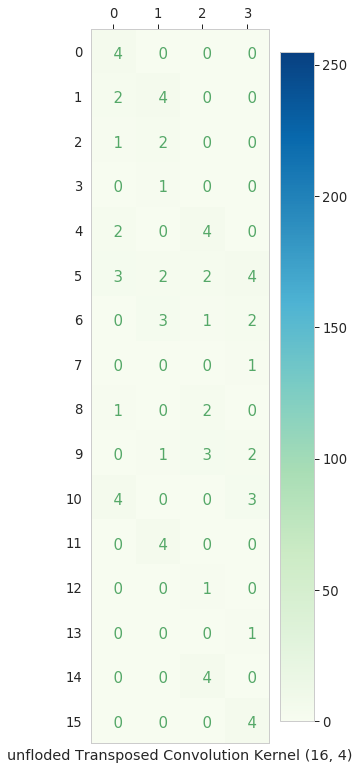

In [37]:
kernel_unfloded_transposed = kernel_unfloded.T
show_kernel(kernel_unfloded_transposed, title='unfloded Transposed Convolution Kernel')


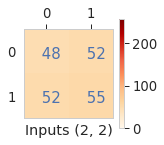

In [29]:
inputs_trconv = output.copy()
show_inputs(inputs_trconv)


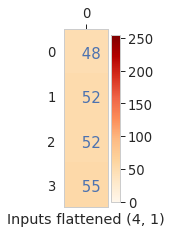

In [30]:
inputs_trconv_flattened = inputs_trconv.reshape(4, 1)
show_inputs(inputs_trconv_flattened, title='Inputs flattened')


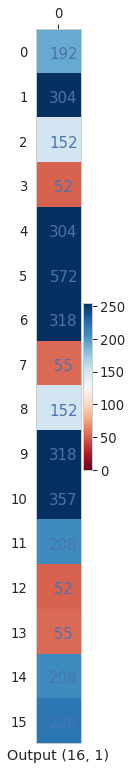

In [43]:
output_trconv_flattened = kernel_unfloded_transposed @ inputs_trconv_flattened
show_output(output_trconv_flattened)


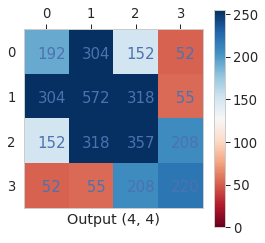

In [44]:
output_trconv = output_trconv.reshape(4, 4)
show_output(output_trconv)


## The aformantioned process can be verified by pytorch operations/


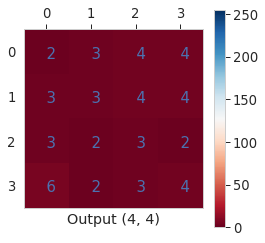

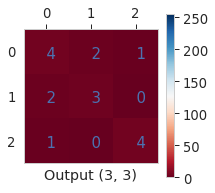

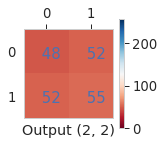

In [33]:
inputs_tensor = torch.from_numpy(inputs)[None, None, :, :].view(1, 1, 4, 4).type(torch.float)
kernel_tensor = torch.from_numpy(kernel)[None, None, :, :].view(1, 1, 3, 3).type(torch.float)

output_tensor = F.conv2d(input=inputs_tensor, weight=kernel_tensor, 
                         bias=None, stride=1, padding=0, dilation=1, groups=1)

show_output(inputs_tensor.squeeze().numpy())
show_output(kernel_tensor.squeeze().numpy())
show_output(output_tensor.squeeze().numpy())

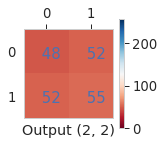

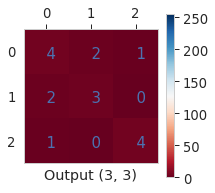

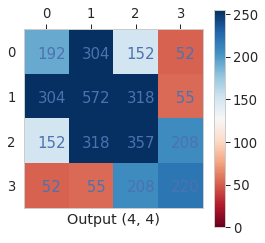

In [36]:
inputs_trconv_tensor = torch.from_numpy(inputs_trconv)[None, None, :, :].view(1, 1, 2, 2).type(torch.float)

output_trconv_tensor = F.conv_transpose2d(input=inputs_trconv_tensor, weight=kernel_tensor, 
                                          bias=None, stride=1, padding=0, dilation=1, groups=1)

show_output(inputs_trconv_tensor.squeeze().numpy())
show_output(kernel_tensor.squeeze().numpy())
show_output(output_trconv_tensor.squeeze().numpy())